In [1]:
import torch

In [2]:
import cv2

In [3]:
import numpy as np

In [4]:
from ultralytics import YOLO

In [5]:
import ultralytics

In [6]:
model = torch.hub.load('ultralytics/yolov5', 'custom', path="../models/best.pt", force_reload=True) 

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /home/mikolaj/.cache/torch/hub/master.zip
YOLOv5 🚀 2024-8-22 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (NVIDIA GeForce GTX 960, 4028MiB)

Fusing layers... 
Model summary: 157 layers, 7020913 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


In [7]:
model.eval()

AutoShape(
  (model): DetectMultiBackend(
    (model): DetectionModel(
      (model): Sequential(
        (0): Conv(
          (conv): Conv2d(3, 32, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
          (act): SiLU(inplace=True)
        )
        (1): Conv(
          (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (act): SiLU(inplace=True)
        )
        (2): C3(
          (cv1): Conv(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv2): Conv(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv3): Conv(
            (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (m): Sequential(
            (0): Bottleneck(
              (cv1): Conv(
                (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  

In [8]:
from dataclasses import dataclass


@dataclass(frozen=True)
class BYTETrackerArgs:
    track_thresh: float = 0.25
    track_buffer: int = 30
    match_thresh: float = 0.8
    aspect_ratio_thresh: float = 3.0
    min_box_area: float = 1.0
    mot20: bool = False

In [9]:
from __future__ import annotations
from dataclasses import dataclass, field
from typing import Tuple, Optional, List, Dict, Any

import cv2

import numpy as np


# geometry utilities


@dataclass(frozen=True)
class Point:
    x: float
    y: float
    
    @property
    def int_xy_tuple(self) -> Tuple[int, int]:
        return int(self.x), int(self.y)


@dataclass(frozen=True)
class Rect:
    x: float
    y: float
    width: float
    height: float

    @property
    def min_x(self) -> float:
        return self.x
    
    @property
    def min_y(self) -> float:
        return self.y
    
    @property
    def max_x(self) -> float:
        return self.x + self.width
    
    @property
    def max_y(self) -> float:
        return self.y + self.height
        
    @property
    def top_left(self) -> Point:
        return Point(x=self.x, y=self.y)
    
    @property
    def bottom_right(self) -> Point:
        return Point(x=self.x + self.width, y=self.y + self.height)

    @property
    def bottom_center(self) -> Point:
        return Point(x=self.x + self.width / 2, y=self.y + self.height)

    @property
    def top_center(self) -> Point:
        return Point(x=self.x + self.width / 2, y=self.y)

    @property
    def center(self) -> Point:
        return Point(x=self.x + self.width / 2, y=self.y + self.height / 2)

    def pad(self, padding: float) -> Rect:
        return Rect(
            x=self.x - padding, 
            y=self.y - padding,
            width=self.width + 2*padding,
            height=self.height + 2*padding
        )
    
    def contains_point(self, point: Point) -> bool:
        return self.min_x < point.x < self.max_x and self.min_y < point.y < self.max_y


# detection utilities


@dataclass
class Detection:
    rect: Rect
    class_id: int
    class_name: str
    confidence: float
    tracker_id: Optional[int] = None

    @classmethod
    def from_results(cls, pred: np.ndarray, names: Dict[int, str]) -> List[Detection]:
        result = []
        for x_min, y_min, x_max, y_max, confidence, class_id in pred:
            class_id=int(class_id)
            result.append(Detection(
                rect=Rect(
                    x=float(x_min),
                    y=float(y_min),
                    width=float(x_max - x_min),
                    height=float(y_max - y_min)
                ),
                class_id=class_id,
                class_name=names[class_id],
                confidence=float(confidence)
            ))
        return result


def filter_detections_by_class(detections: List[Detection], class_name: str) -> List[Detection]:
    return [
        detection
        for detection 
        in detections
        if detection.class_name == class_name
    ]


# draw utilities


@dataclass(frozen=True)
class Color:
    r: int
    g: int
    b: int
        
    @property
    def bgr_tuple(self) -> Tuple[int, int, int]:
        return self.b, self.g, self.r

    @classmethod
    def from_hex_string(cls, hex_string: str) -> Color:
        r, g, b = tuple(int(hex_string[1 + i:1 + i + 2], 16) for i in (0, 2, 4))
        return Color(r=r, g=g, b=b)


def draw_rect(image: np.ndarray, rect: Rect, color: Color, thickness: int = 2) -> np.ndarray:
    cv2.rectangle(image, rect.top_left.int_xy_tuple, rect.bottom_right.int_xy_tuple, color.bgr_tuple, thickness)
    return image


def draw_filled_rect(image: np.ndarray, rect: Rect, color: Color) -> np.ndarray:
    cv2.rectangle(image, rect.top_left.int_xy_tuple, rect.bottom_right.int_xy_tuple, color.bgr_tuple, -1)
    return image


def draw_polygon(image: np.ndarray, countour: np.ndarray, color: Color, thickness: int = 2) -> np.ndarray:
    cv2.drawContours(image, [countour], 0, color.bgr_tuple, thickness)
    return image


def draw_filled_polygon(image: np.ndarray, countour: np.ndarray, color: Color) -> np.ndarray:
    cv2.drawContours(image, [countour], 0, color.bgr_tuple, -1)
    return image


def draw_text(image: np.ndarray, anchor: Point, text: str, color: Color, thickness: int = 2) -> np.ndarray:
    cv2.putText(image, text, anchor.int_xy_tuple, cv2.FONT_HERSHEY_SIMPLEX, 0.7, color.bgr_tuple, thickness, 2, False)
    return image


def draw_ellipse(image: np.ndarray, rect: Rect, color: Color, thickness: int = 2) -> np.ndarray:
    cv2.ellipse(
        image,
        center=rect.bottom_center.int_xy_tuple,
        axes=(int(rect.width), int(0.35 * rect.width)),
        angle=0.0,
        startAngle=-45,
        endAngle=235,
        color=color.bgr_tuple,
        thickness=thickness,
        lineType=cv2.LINE_4
    )
    return image


# base annotator
  

@dataclass
class BaseAnnotator:
    colors: List[Color]
    thickness: int

    def annotate(self, image: np.ndarray, detections: List[Detection]) -> np.ndarray:
        annotated_image = image.copy()
        for detection in detections:
            annotated_image = draw_ellipse(
                image=image,
                rect=detection.rect,
                color=self.colors[detection.class_id],
                thickness=self.thickness
            )
        return annotated_image

In [10]:
from typing import Generator
def generate_frames(video_file: str) -> Generator[np.ndarray, None, None]:
    video = cv2.VideoCapture(video_file)

    while video.isOpened():
        success, frame = video.read()

        if not success:
            break

        yield frame

    video.release()


In [11]:

def plot_image(image: np.ndarray, size: int = 12) -> None:
    plt.figure(figsize=(size, size))
    plt.imshow(image[...,::-1])
    plt.show()

In [12]:

# white
BALL_COLOR_HEX = "#FFFFFF"
BALL_COLOR = Color.from_hex_string(BALL_COLOR_HEX)

# red
GOALKEEPER_COLOR_HEX = "#850101"
GOALKEEPER_COLOR = Color.from_hex_string(GOALKEEPER_COLOR_HEX)

# green
PLAYER_COLOR_HEX = "#00D4BB"
PLAYER_COLOR = Color.from_hex_string(PLAYER_COLOR_HEX)

# yellow
REFEREE_COLOR_HEX = "#FFFF00"
REFEREE_COLOR = Color.from_hex_string(REFEREE_COLOR_HEX)

COLORS = [
    BALL_COLOR,
    GOALKEEPER_COLOR,
    PLAYER_COLOR,
    REFEREE_COLOR
]
THICKNESS = 4

In [18]:
frame_iterator = iter(generate_frames(video_file="../test_videos/test_video.mp4"))

In [19]:
import matplotlib.pyplot as plt


In [27]:
# %matplotlib inline


/home/mikolaj/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:869: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


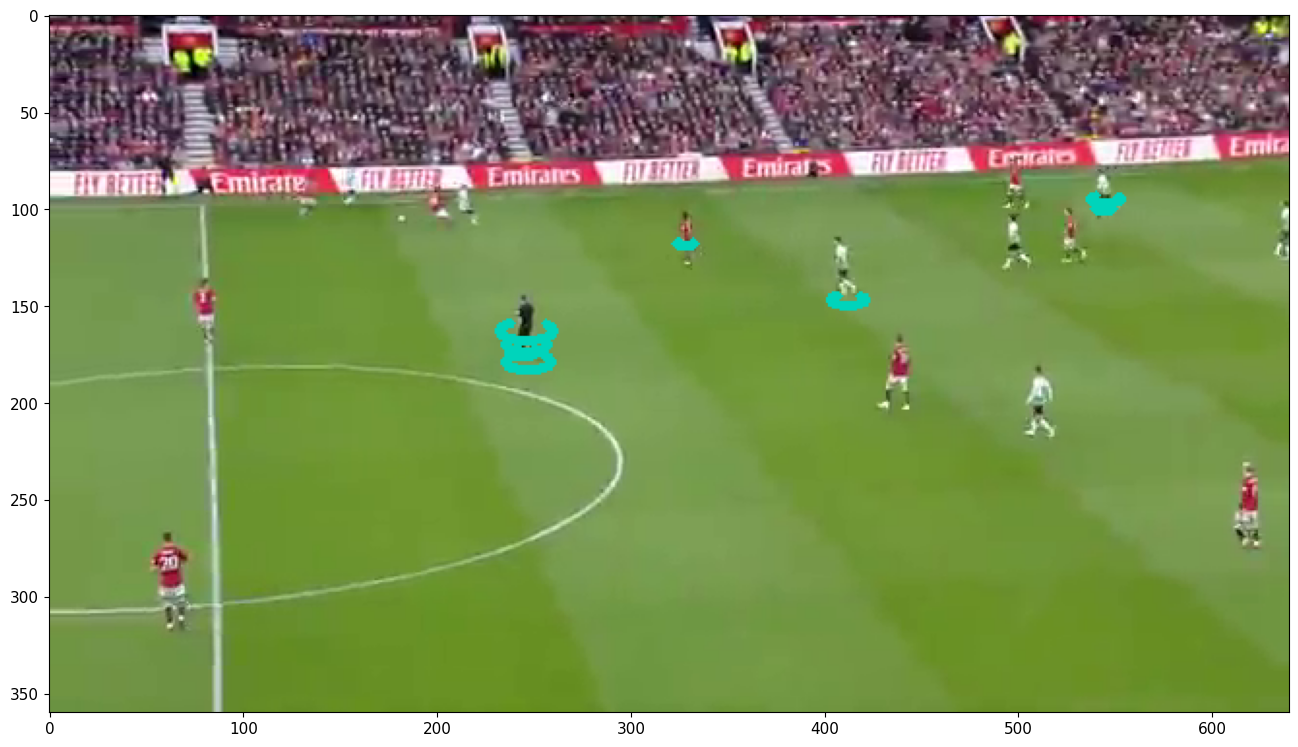

In [28]:
# initiate annotators
annotator = BaseAnnotator(
    colors=COLORS, 
    thickness=THICKNESS)

# acquire video frame
frame = next(frame_iterator)
if frame is None:
    raise ValueError("Frame is None, please check the video source.")
# run detector
results = model(frame, size=1280)
detections = Detection.from_results(
    pred=results.pred[0].cpu().numpy(), 
    names=model.names)

# annotate video frame
annotated_image = annotator.annotate(
    image=frame, 
    detections=detections)

# plot video frame
plot_image(annotated_image, 16)
plt.show()